In [1]:
!pip install torch

In [66]:
from sklearn.datasets import make_circles

In [67]:
n_samples = 1000

In [68]:
X,y = make_circles(n_samples=n_samples,
                   noise=0.05,
                    random_state=42)

In [69]:
print(f"first 5 x : \n{X[:5]}")
print(f"first 5 y : \n{y[:5]}")

first 5 x : 
[[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
first 5 y : 
[1 1 1 1 0]


In [70]:
import pandas as pd
circles = pd.DataFrame({
    "X1":X[:,0],
    "X2":X[:,1],
    "label":y
})


In [71]:
circles.head()

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


In [72]:
circles.label.value_counts()

,count
label,
1,500
0,500


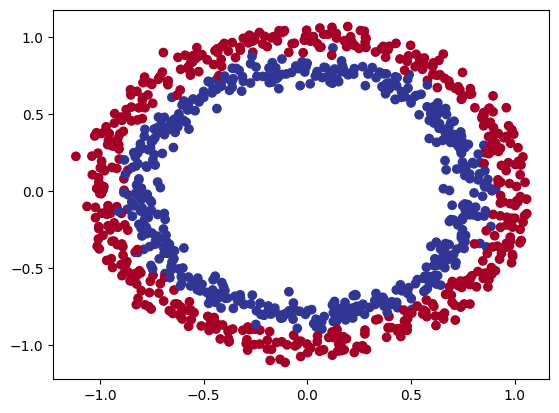

In [73]:
import matplotlib.pyplot as plt
plt.scatter(
    x=X[:,0],
    y=X[:,1],
    c=y,
    cmap=plt.cm.RdYlBu
)

In [74]:
X.shape,y.shape

((1000, 2), (1000,))

In [75]:
X_sample= X[0]
y_sample = y[0]


In [76]:
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.74220688 0.24668576] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [77]:
## turn data into tensors

In [78]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

##view the first five samples
X[:5],y[:5]

(tensor([[ 0.7422,  0.2467],
         [-0.7340,  0.1687],
         [-0.8299,  0.2220],
         [-0.4291,  0.6722],
         [ 0.4456, -0.8949]]),
 tensor([1., 1., 1., 1., 0.]))

In [79]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [80]:
import torch
from torch import nn

##make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [81]:
## construct a model by subclassing nn.Module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=50)
        self.layer_3 = nn.Linear(in_features=50,out_features=5)
        self.layer_4 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        return x

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=50, bias=True)
  (layer_3): Linear(in_features=50, out_features=5, bias=True)
  (layer_4): Linear(in_features=5, out_features=1, bias=True)
)

In [82]:
## Replicing the above model with seqeuntial

model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=50),
    nn.Linear(in_features=50,out_features=5),
    nn.Linear(in_features=5,out_features=1),
).to(device)


In [83]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=50, bias=True)
  (2): Linear(in_features=50, out_features=5, bias=True)
  (3): Linear(in_features=5, out_features=1, bias=True)
)

In [84]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4408],
        [0.4747],
        [0.3523],
        [0.4689],
        [0.3464],
        [0.3686],
        [0.4682],
        [0.4447],
        [0.3474],
        [0.4762]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [85]:
## Create a loss function

In [86]:
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [87]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [88]:
## Train a model

In [89]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4408],
        [0.4747],
        [0.3523],
        [0.4689],
        [0.3464]], device='cuda:0', grad_fn=<SliceBackward0>)

In [90]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6084],
        [0.6165],
        [0.5872],
        [0.6151],
        [0.5857]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [91]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [92]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [93]:
### Build 3.2 training and testing loop

In [94]:
torch.manual_seed(42)

epochs = 100

# put data to target device
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

##build training and evalute loop

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testing
  model_0.eval()

  with torch.inference_mode():
    # 1 forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71252 | Accuracy: 50.00% | Test Loss: 0.71233 | Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.69597 | Accuracy: 50.00% | Test Loss: 0.69801 | Test Accuracy: 50.00%
Epoch: 20 | Loss: 0.69342 | Accuracy: 57.25% | Test Loss: 0.69564 | Test Accuracy: 53.00%
Epoch: 30 | Loss: 0.69305 | Accuracy: 52.25% | Test Loss: 0.69519 | Test Accuracy: 46.50%
Epoch: 40 | Loss: 0.69300 | Accuracy: 51.38% | Test Loss: 0.69505 | Test Accuracy: 47.00%
Epoch: 50 | Loss: 0.69299 | Accuracy: 51.50% | Test Loss: 0.69498 | Test Accuracy: 45.50%
Epoch: 60 | Loss: 0.69299 | Accuracy: 51.12% | Test Loss: 0.69493 | Test Accuracy: 46.00%
Epoch: 70 | Loss: 0.69298 | Accuracy: 51.38% | Test Loss: 0.69489 | Test Accuracy: 46.00%
Epoch: 80 | Loss: 0.69298 | Accuracy: 51.38% | Test Loss: 0.69485 | Test Accuracy: 46.00%
Epoch: 90 | Loss: 0.69298 | Accuracy: 51.38% | Test Loss: 0.69483 | Test Accuracy: 46.00%


In [95]:
## downloading the helper_functions.py scrips from

In [96]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


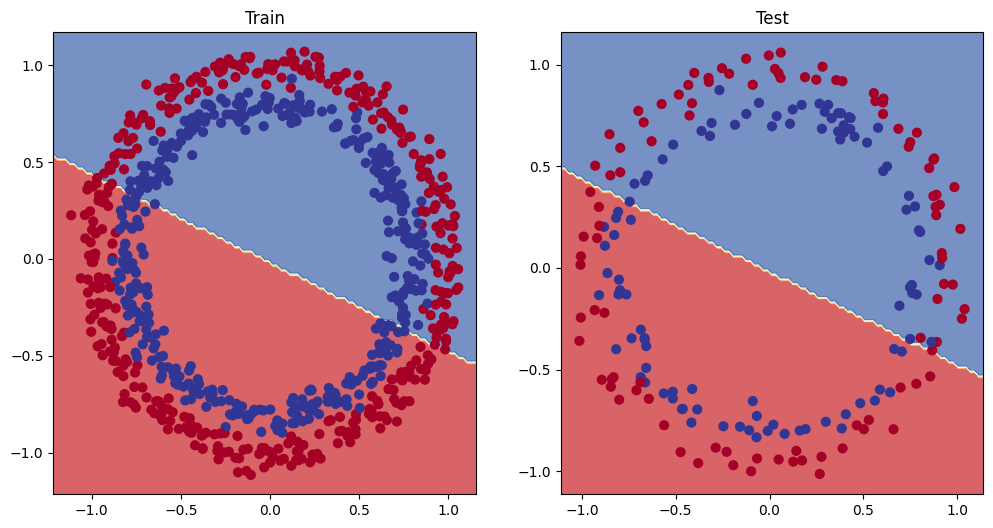

In [97]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [98]:
## construct a model by subclassing nn.Module

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=100)
        self.layer_3 = nn.Linear(in_features=100,out_features=50)
        self.layer_4 = nn.Linear(in_features=50,out_features=1)

    def forward(self,x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        return x

# 4. Create an instance of the model and send it to target device
model_1 = CircleModelV0().to(device)
model_1

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=50, bias=True)
  (layer_3): Linear(in_features=50, out_features=5, bias=True)
  (layer_4): Linear(in_features=5, out_features=1, bias=True)
)

In [99]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [100]:
torch.manual_seed(42)

epochs =1000
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  ##calculate loss and accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    #1 forward_ward
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2 calculate loss/accuracy
    test_loss = loss_fn(test_logits,
                       y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70361, Accuracy: 50.00% | Test loss: 0.70035, Test acc: 50.00%
Epoch: 100 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69453, Test acc: 46.50%
Epoch: 200 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69462, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.50%


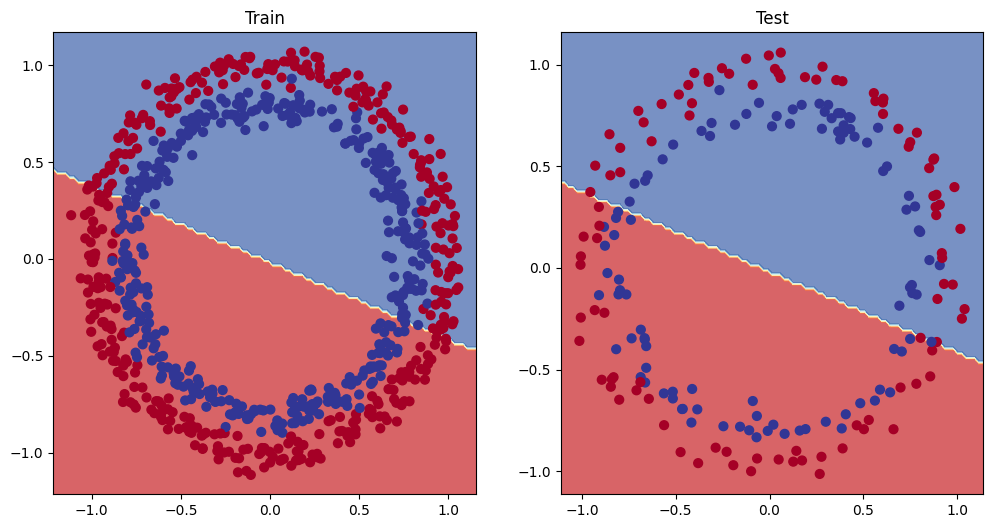

In [101]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [102]:
### 5.1 Preparing data to see if our model can model a straight line
# Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

In [103]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [104]:
##create a train and test splits

train_split = int(0.8*len(X_regression))
X_train_regression,y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression,y_test_regression = X_regression[train_split:],y_regression[train_split:]

In [105]:
##check the lengths of each split

In [106]:
print(
    len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression)
)

80 80 20 20


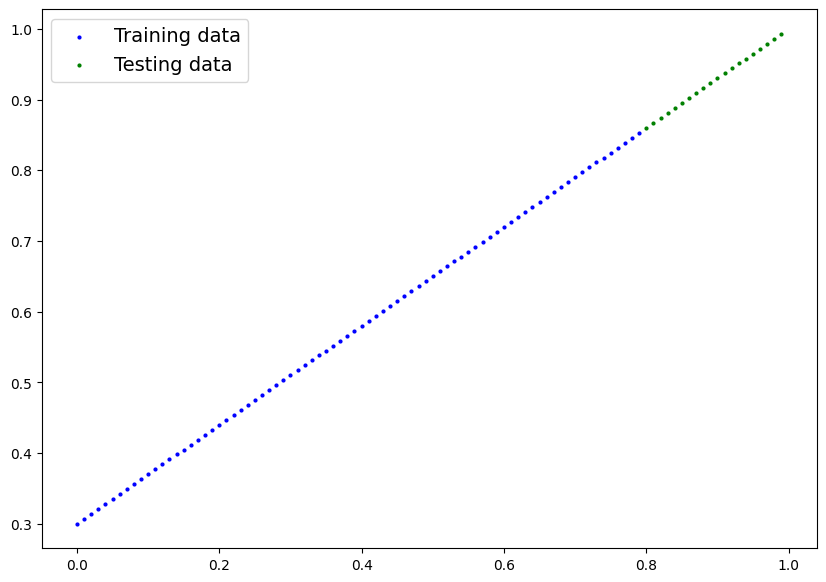

In [107]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [108]:
## adjusting model 1 to fit a stright line

In [109]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=100),
    nn.Linear(in_features=100, out_features=50),
    nn.Linear(in_features=50, out_features=1),

).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=100, bias=True)
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Linear(in_features=50, out_features=1, bias=True)
)

In [110]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [111]:
##Train the model

In [112]:
torch.manual_seed(42)

epochs = 1000

X_train_regression,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device),y_test_regression.to(device)

for epoch in range(epochs):
  #1 forward pass
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ##testing
  model_2.eval()

  with torch.inference_mode():
    #forward pass
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  if epoch %100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.69341, Test loss: 0.12278
Epoch: 100 | Train loss: 0.07257, Test loss: 0.18580
Epoch: 200 | Train loss: 0.04228, Test loss: 0.14888
Epoch: 300 | Train loss: 0.09792, Test loss: 0.07489
Epoch: 400 | Train loss: 0.08605, Test loss: 0.09360
Epoch: 500 | Train loss: 0.08472, Test loss: 0.08358
Epoch: 600 | Train loss: 0.05219, Test loss: 0.14071
Epoch: 700 | Train loss: 0.09075, Test loss: 0.03675
Epoch: 800 | Train loss: 0.04054, Test loss: 0.03615
Epoch: 900 | Train loss: 0.07957, Test loss: 0.02454


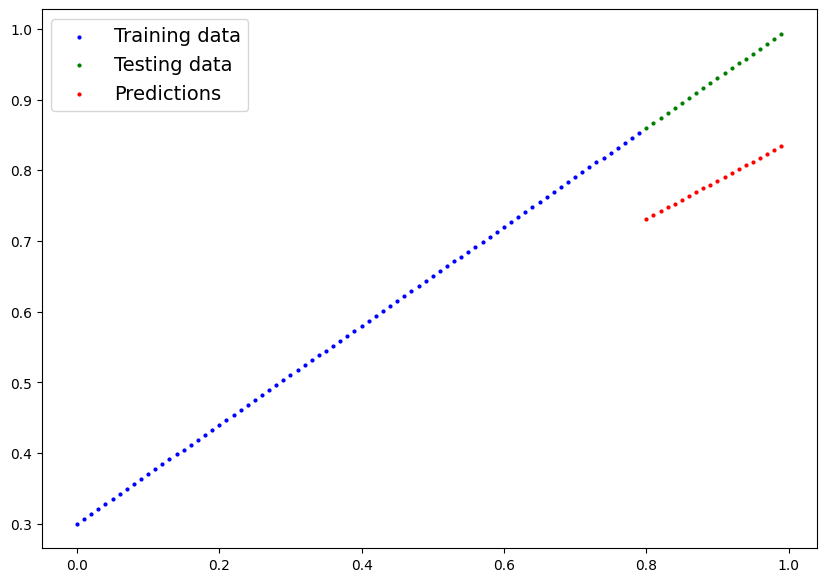

In [113]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## model is able to learn on linear data and plot stright line

In [114]:
##Recreating a non-linear data

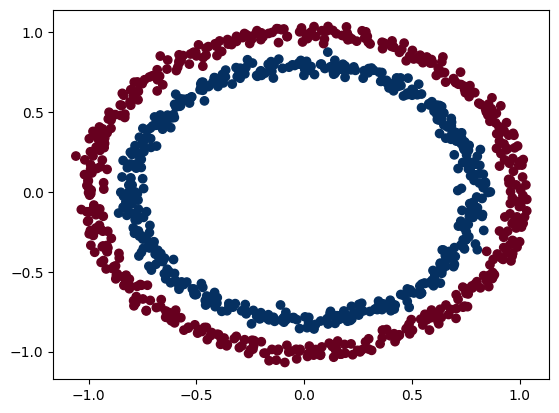

In [115]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [116]:
#convert to tensors and split into train and test sets

In [117]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [118]:
X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [119]:
## Building a model with non-linearity

In [121]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
      # Intersperse the ReLU activation function between layers
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [122]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## train a model with non-linearity

In [124]:
torch.manual_seed(42)

epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  ##optimizer zero grad
  optimizer.zero_grad()

  #4. loss backward
  loss.backward()

  #5. optimizer  steps
  optimizer.step()

  ### testing
  model_3.eval()
  with torch.inference_mode():
    # 1 forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. calculate loss and accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  # print out what's happening
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.63704, Accuracy: 75.38% | Test Loss: 0.64986, Test Accuracy: 70.50%
Epoch: 100 | Loss: 0.60417, Accuracy: 83.88% | Test Loss: 0.62281, Test Accuracy: 75.50%
Epoch: 200 | Loss: 0.54577, Accuracy: 91.00% | Test Loss: 0.57083, Test Accuracy: 86.00%
Epoch: 300 | Loss: 0.44975, Accuracy: 94.75% | Test Loss: 0.48127, Test Accuracy: 92.50%
Epoch: 400 | Loss: 0.35091, Accuracy: 92.75% | Test Loss: 0.39334, Test Accuracy: 89.00%
Epoch: 500 | Loss: 0.36301, Accuracy: 82.25% | Test Loss: 0.43309, Test Accuracy: 75.00%
Epoch: 600 | Loss: 0.18353, Accuracy: 98.62% | Test Loss: 0.22393, Test Accuracy: 97.00%
Epoch: 700 | Loss: 0.11449, Accuracy: 99.75% | Test Loss: 0.15409, Test Accuracy: 99.00%
Epoch: 800 | Loss: 0.07802, Accuracy: 100.00% | Test Loss: 0.11092, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.05710, Accuracy: 100.00% | Test Loss: 0.08716, Test Accuracy: 99.50%


In [125]:
##6.4 evaluating a model trained  with non-liner activation functions

In [126]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10],y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

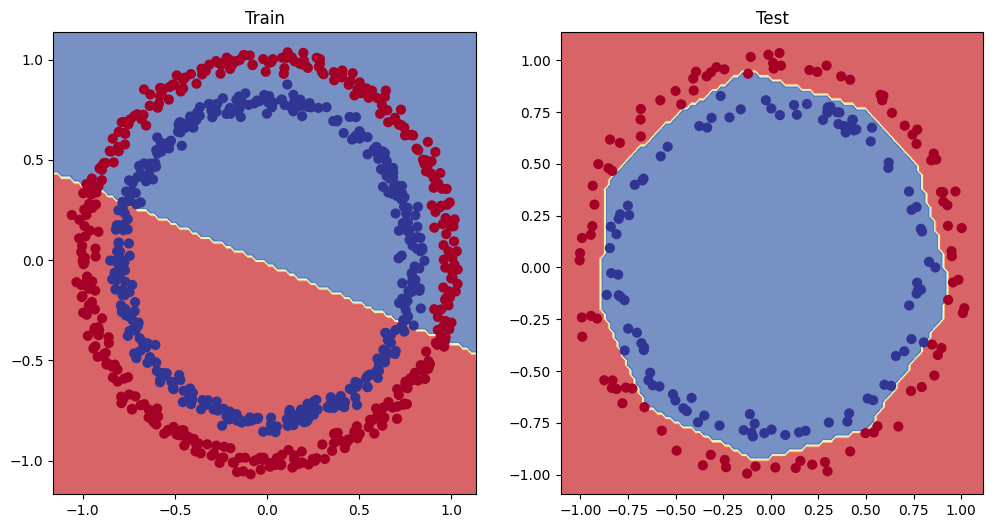

In [127]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Replicating non-linear activation functions

In [128]:
## create a toy tensor

In [129]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

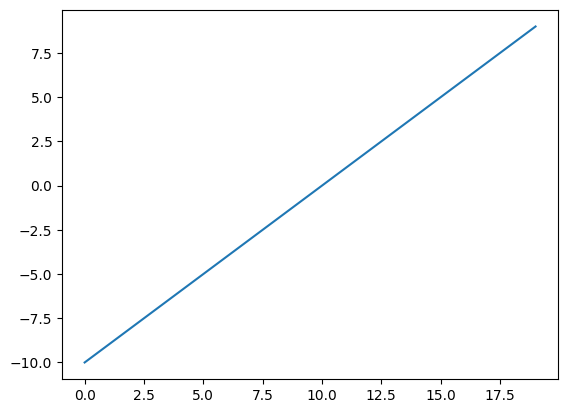

In [130]:
plt.plot(A);

In [131]:
# Create ReLU function by hand
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

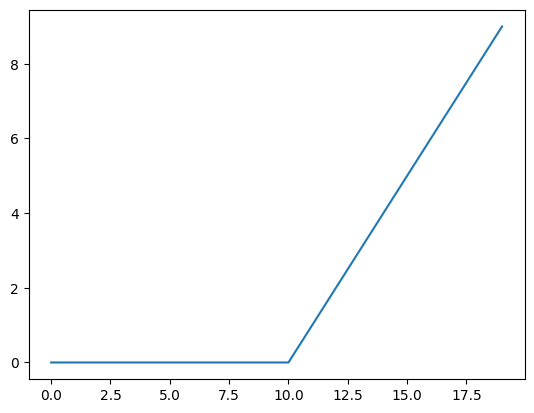

In [132]:
plt.plot(relu(A));

In [133]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

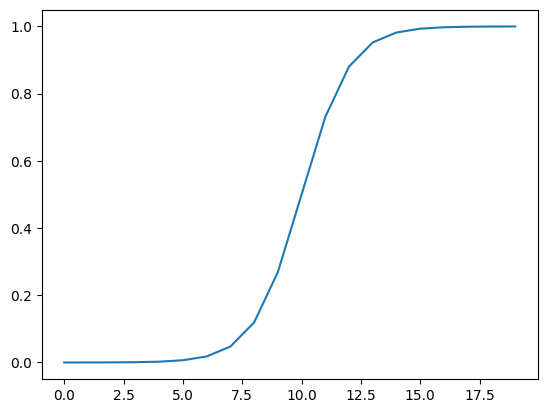

In [134]:
plt.plot(sigmoid(A));

## Building a multi clas Classifbom model

In [135]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [137]:
## SET_HYPERRAMATERS
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1 . create mult class data
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

## turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

print(X_blob[:5],y_blob[:5])

#3. split into train and test sets

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [138]:
X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

In [139]:
## 4. plot data

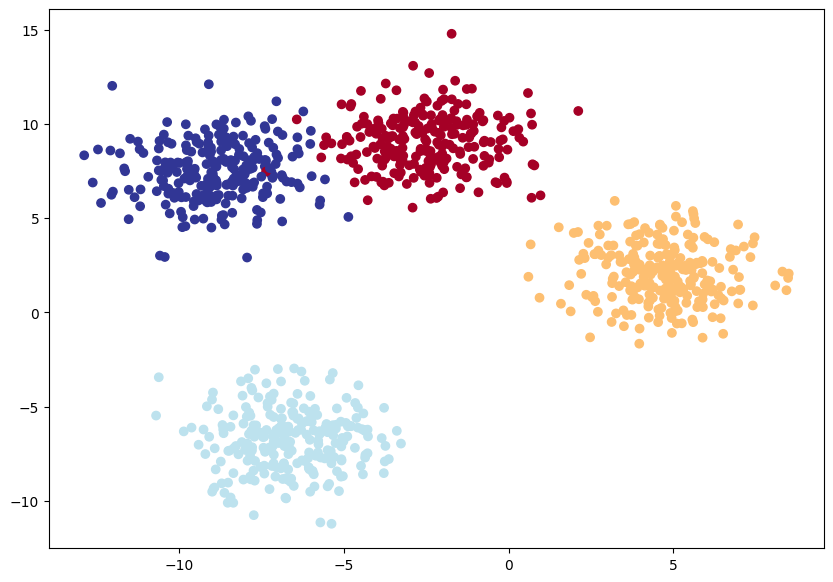

In [140]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [141]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [142]:
from torch import nn

class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units):
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.liner_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.liner_layer_stack(x)

In [145]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=8
).to(device)

In [146]:
model_4

BlobModel(
  (liner_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [147]:
## Setting up the loss and optimizer functions

In [148]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),lr=0.1)

In [149]:
## Getting prediction probalities for a multi class pytorch model

In [150]:
model_4(X_blob_test.to(device))[:5]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [151]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [152]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [153]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [154]:
#checking which index is  highest
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


## Creating training and testing loop

In [157]:
torch.manual_seed(42)

# set number of epochs

epochs = 100

X_blob_train , y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test , y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  ### training
  model_4.train()

  # 1. forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  ##optimizer zero grad
  optimizer.zero_grad()

  #4. loss backwards
  loss.backward()

  #5. optimizer step
  optimizer.step()

  ### testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
    # calculate test loss and accuracy
    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_pred)
    # print out what's happening

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Accuracy: 65.50% | Test Loss: 0.57861, Test Accuracy: 95.50%
Epoch: 10 | Loss: 0.14398, Accuracy: 99.12% | Test Loss: 0.13037, Test Accuracy: 99.00%
Epoch: 20 | Loss: 0.08062, Accuracy: 99.12% | Test Loss: 0.07216, Test Accuracy: 99.50%
Epoch: 30 | Loss: 0.05924, Accuracy: 99.12% | Test Loss: 0.05133, Test Accuracy: 99.50%
Epoch: 40 | Loss: 0.04892, Accuracy: 99.00% | Test Loss: 0.04098, Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.04295, Accuracy: 99.00% | Test Loss: 0.03486, Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.03910, Accuracy: 99.00% | Test Loss: 0.03083, Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.03643, Accuracy: 99.00% | Test Loss: 0.02799, Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.03448, Accuracy: 99.00% | Test Loss: 0.02587, Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.03300, Accuracy: 99.12% | Test Loss: 0.02423, Test Accuracy: 99.50%


In [158]:
##8.6 Making and evaluating predictions with a Pytorchh Multi class model

In [159]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [160]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


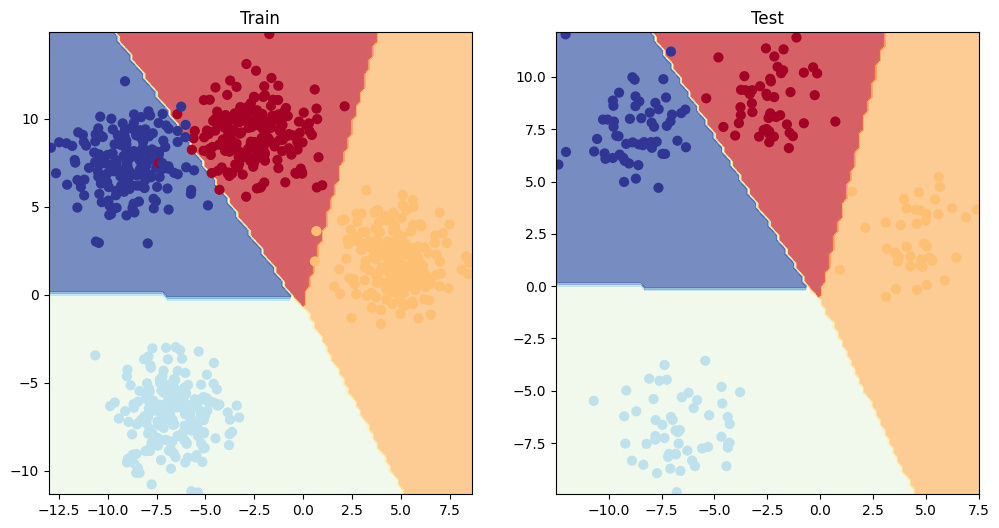

In [161]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [162]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 11.5 MB/s eta 0:00:00


tensor(0.9950, device='cuda:0')

In [ ]:
## Exercices will me implemenet afterwards